In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
from semiparametric import SemiparametricRegressionMP
from nonparametric import NonparametricRegressionMP
from alpha import Alpha, GaussianCopulaD

from utils import phi, Phi
from dataset import LIDAR

In [3]:
lidar_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath("main.ipynb"))), "datasets/lidar.csv")

data = LIDAR(path=lidar_path)

Text(0, 0.5, 'y')

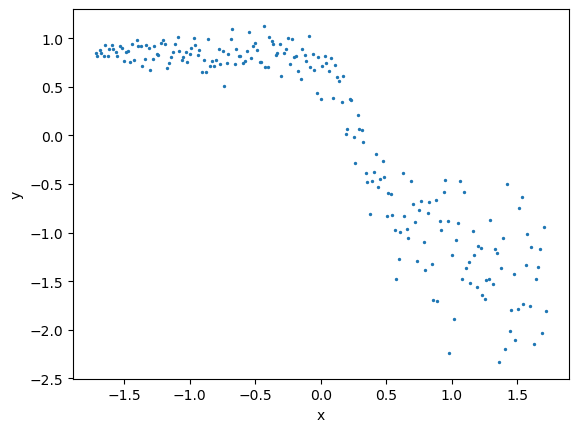

In [4]:
plt.scatter(x=data.x, y=data.y, s=2)
plt.xlabel("x")
plt.ylabel("y")

## Nonparametric

In [5]:
alpha = Alpha(alpha=0.4, d=GaussianCopulaD(rho=0.93))
rho = 0.8

p0 = lambda x, y: phi(y)
P0 = lambda x, y: Phi(y)

In [6]:
nmp = NonparametricRegressionMP(p0=p0, P0=P0, rho=rho, alpha=alpha)

In [7]:
nmp.train(data.x, data.y)

In [8]:
_nx, _ny = 100, 300
_ypad = 1
x_linspace = np.linspace(data.x.min(), data.x.max(), _nx)
y_linepsace = np.linspace(data.y.min()-_ypad, data.y.max()+_ypad, _ny)

dy = y_linepsace[1] - y_linepsace[0]

x_test, y_test = np.meshgrid(x_linspace, y_linepsace)

In [9]:
sim_n = len(data)
all_Ps, all_ps = nmp.get(x_test.flatten(), y_test.flatten(), n=sim_n)

In [10]:
Ps = all_Ps[-1].reshape(_ny, _nx)
ps = all_ps[-1].reshape(_ny, _nx)

Ey = lambda gy: np.sum(ps * dy * gy, axis=0, keepdims=True)

ps.shape

(300, 100)

In [11]:
nmp_mean = Ey(y_test)
nmp_var = Ey((y_test - nmp_mean)**2)
nmp_std = np.sqrt(nmp_var)
nmp_skew = Ey(((y_test - nmp_mean)/nmp_std)**3)

nmp_p025 = np.zeros((_nx,))
nmp_p975 = np.zeros((_nx,))
for j in range(_nx):
    nmp_p025[j] = y_linepsace[np.searchsorted(Ps[:, j], 0.025)-1]
    nmp_p975[j] = y_linepsace[np.searchsorted(Ps[:, j], 0.975)-1]

nmp_mean, nmp_var, nmp_std, nmp_skew = nmp_mean[0], nmp_var[0], nmp_std[0], nmp_skew[0]

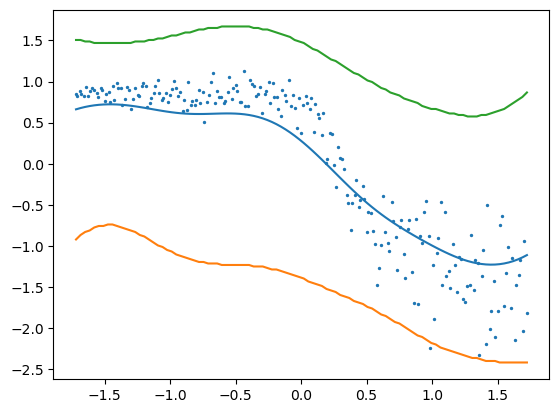

In [12]:
## Theres some bugs here
plt.scatter(x=data.x, y=data.y, s=2)

plt.plot(x_linspace, nmp_mean)
plt.plot(x_linspace, nmp_p025)
plt.plot(x_linspace, nmp_p975)

## Semiparametric

In [13]:
alpha = Alpha(alpha=0.4, d=GaussianCopulaD(rho=0.93))
rho = 0.8

def moment_init(x):
    return np.array([
        np.zeros(x.shape),
        np.ones(x.shape)/4,
        np.zeros(x.shape)
    ])

In [14]:
mp = SemiparametricRegressionMP(ms_0=moment_init, n_moments=3, rho=rho, alpha=alpha)

In [15]:
mp.train(data.x, data.y)

In [16]:
x_linspace = np.linspace(data.x.min(), data.x.max(), 100)

In [17]:
sim_n = len(data)
result = mp.get(x_linspace, n=sim_n)

Text(0, 0.5, 'y')

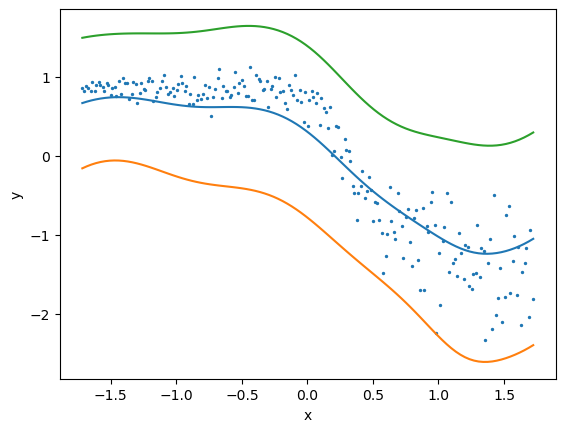

In [18]:
plt.scatter(x=data.x, y=data.y, s=2)

plt.plot(x_linspace, result["mu"][-1])
plt.plot(x_linspace, result["mu"][-1]-result["sigma"][-1]*1.96)
plt.plot(x_linspace, result["mu"][-1]+result["sigma"][-1]*1.96)

plt.xlabel("x")
plt.ylabel("y")

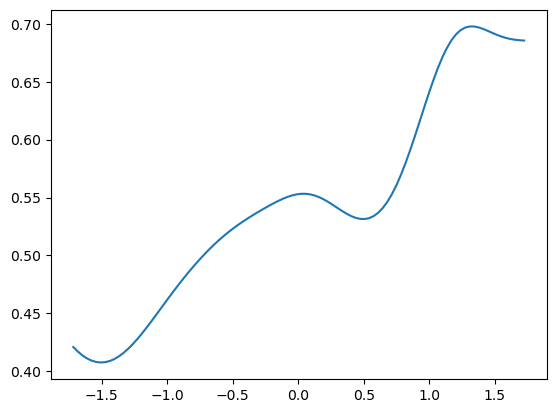

In [19]:
plt.plot(x_linspace, result["sigma"][-1])

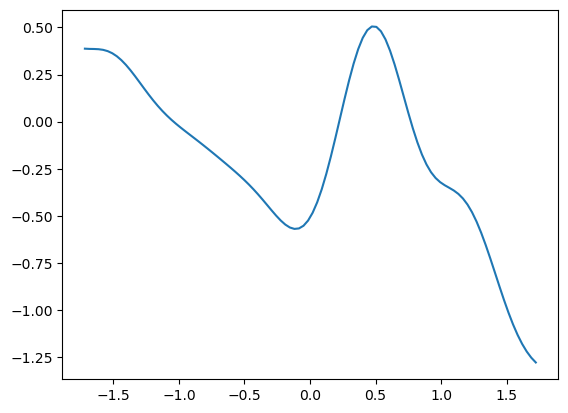

In [20]:
skew_func = lambda mu, sigma, m2, m3: (m3 - 2*m2*mu + 2*mu**3)/sigma**3
plt.plot(x_linspace, skew_func(result["mu"][-1], result["sigma"][-1], result["moments"][1, -1], result["moments"][2, -1]))